In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import numpy as np
import gc
import os
import optuna
import sqlite3
import ray
import matplotlib.pyplot as plt
import polars as pl
from optuna.integration import LightGBMPruningCallback
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed
from more_itertools import chunked
from functools import reduce
from typing import List
from itertools import combinations


In [2]:
# Reducir memoria automáticamente
def optimizar_memoria(df):
    for col in df.select_dtypes(include=['int64', 'int32']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64', 'float32']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

In [3]:
# Abrir el archivo parquet y cargarlo en un DataFrame data/l_vm_completa_train_pendientes.parquet
gc.collect()
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')

In [4]:
df_full.shape

(17021654, 76)

In [5]:
# Buscar en df_full los product_id, customer_id que solo tienen ceros en TN
def buscar_productos_solo_ceros(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby(['PRODUCT_ID', 'CUSTOMER_ID'])['TN'].sum().reset_index()
    productos_solo_ceros = grouped[grouped['TN'] == 0]
    return productos_solo_ceros

productos_solo_ceros = buscar_productos_solo_ceros(df_full)
print(f"🔍 Combinaciones PRODUCT_ID + CUSTOMER_ID con TN = 0 en todos sus registros: {len(productos_solo_ceros)}")

# Eliminar del df_full los product_id, customer_id que solo tienen ceros en TN
def eliminar_productos_solo_ceros(df: pd.DataFrame, productos_solo_ceros: pd.DataFrame) -> pd.DataFrame:
    productos_set = set(zip(productos_solo_ceros['PRODUCT_ID'], productos_solo_ceros['CUSTOMER_ID']))
    mask = df.set_index(['PRODUCT_ID', 'CUSTOMER_ID']).index.isin(productos_set)
    
    cantidad_eliminada = mask.sum()
    print(f"🗑️ Filas eliminadas de df_full: {cantidad_eliminada:,}")
    
    df_filtrado = df[~mask]
    return df_filtrado

df_full = eliminar_productos_solo_ceros(df_full, productos_solo_ceros)


🔍 Combinaciones PRODUCT_ID + CUSTOMER_ID con TN = 0 en todos sus registros: 327068
🗑️ Filas eliminadas de df_full: 6,594,430
🗑️ Filas eliminadas de df_full: 6,594,430


In [6]:
# Eliminar de df_full las filas donde la columna A_PREDECIR sea 'N'
df_full = df_full[df_full['A_PREDECIR'] != 'N']
df_full = df_full.drop(columns=['A_PREDECIR'])

In [7]:
df_full.shape

(7781619, 75)

In [8]:
# Conservar las siguientes columnas
columns_to_keep = ['PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1',
       'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'CUSTOMER_ID',
       'PRODUCT_ID', 'PLAN_PRECIOS_CUIDADOS', 'CUST_REQUEST_QTY',
       'CUST_REQUEST_TN', 'TN', 'CLASE', 'CLASE_DELTA',
       'ORDINAL', 'ANTIG_CLIENTE',
       'ANTIG_PRODUCTO', 'CANT_PROD_CLI_PER']
# Filtrar el DataFrame para conservar solo las columnas deseadas 
df_full = df_full[columns_to_keep]
df_full['DIAS_EN_MES'] = pd.to_datetime(df_full['PERIODO'], format='%Y%m').dt.days_in_month

In [9]:
df_full = optimizar_memoria(df_full)

In [10]:
# Asegurarse de que df_full es un DataFrame de pandas
if not isinstance(df_full, pd.DataFrame):
    df_full = df_full.to_pandas()

# 1. Ordenar correctamente
df_full = df_full.sort_values(by=['PRODUCT_ID', 'CUSTOMER_ID', 'ORDINAL'], ascending=True)

meses_a_tomar = 18  # Número de meses para crear los LAGs y DELTAs

# 2. Crear los LAGs y DELTAs
for lag in range(1, meses_a_tomar):
    lag_col = f'TN_LAG_{lag:02d}'
    delta_col = f'TN_DELTA_{lag:02d}'

    df_full[lag_col] = df_full.groupby(['PRODUCT_ID', 'CUSTOMER_ID'])['TN'].shift(lag)
    df_full[delta_col] = df_full['TN'] - df_full[lag_col]

# 3. Calcular los porcentajes de cambio como la división de df_full['TN'] / df_full[lag_col]
# si df_full[lag_col] = 0, reemplazar por el mínimo valor de TN en el grupo (scalar, no dict)
minimos_tn = df_full.groupby(['PRODUCT_ID', 'CUSTOMER_ID'])['TN'].transform('min')
delta_pct_cols = {}
for lag in range(1, meses_a_tomar):
    lag_col = f'TN_LAG_{lag:02d}'
    delta_pct_col = f'TN_DELTA_PCT_{lag:02d}'

    # Construir la serie de lag reemplazando 0 por el mínimo del grupo (elementwise)
    lag_values = df_full[lag_col]
    lag_reemplazo = np.where(lag_values == 0, minimos_tn, lag_values)
    # Calcular el porcentaje de cambio
    df_full[delta_pct_col] = df_full['TN'] / lag_reemplazo

    # Reemplazar infinitos y NaN por 0
    df_full[delta_pct_col] = df_full[delta_pct_col].replace([np.inf, -np.inf], 0).fillna(0)

    # Guardar en el diccionario
    delta_pct_cols[delta_pct_col] = df_full[delta_pct_col]

# 4. Defragmentar para mejorar rendimiento
df_full = df_full.copy()
gc.collect()

0

In [11]:
# Agregar una columna que indique la diferencia en ORDINAL entre el ORDINAL actual y el ORDINAL anterior donde TN sea mayor a 0
# para ese CUSTOMER_ID y PRODUCT_ID

from joblib import Parallel, delayed
import numpy as np
import pandas as pd

def calcular_mejoras_por_grupo(grupo):
    grupo = grupo.sort_values('ORDINAL').copy()
    ult_ordinal = None
    valores = []

    for _, row in grupo.iterrows():
        if ult_ordinal is None:
            valores.append(36)
        else:
            valores.append(int(row['ORDINAL'] - ult_ordinal))

        if row['TN'] > 0:
            ult_ordinal = row['ORDINAL']

    grupo['MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID'] = np.array(valores, dtype=np.int16)
    return grupo

def agregar_diferencia_ordinal_parallel(df: pd.DataFrame, n_jobs: int = -1) -> pd.DataFrame:
    df = df.copy()
    df['MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID'] = 36  # valor inicial
    df['MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID'] = df['MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID'].astype('int16')

    # Agrupar por cliente y producto
    grupos = list(df.groupby(['CUSTOMER_ID', 'PRODUCT_ID']))

    # Procesar en paralelo
    resultados = Parallel(n_jobs=n_jobs, backend='loky', batch_size=128)(
        delayed(calcular_mejoras_por_grupo)(grupo) for _, grupo in grupos
    )

    # Concatenar todos los resultados
    df_resultado = pd.concat(resultados, axis=0).sort_index()
    return df_resultado



df_full = agregar_diferencia_ordinal_parallel(df_full, n_jobs=28)

In [12]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd

def calcular_mejoras_por_producto(grupo):
    grupo = grupo.sort_values('ORDINAL').copy()
    ult_ordinal = None
    valores = []

    for _, row in grupo.iterrows():
        if ult_ordinal is None:
            valores.append(36)
        else:
            valores.append(int(row['ORDINAL'] - ult_ordinal))

        if row['TN'] > 0:
            ult_ordinal = row['ORDINAL']

    grupo['MESES_SIN_COMPRAR_PRODUCT_ID'] = np.array(valores, dtype=np.int16)
    return grupo

def agregar_diferencia_ordinal_por_producto(df: pd.DataFrame, n_jobs: int = -1) -> pd.DataFrame:
    df = df.copy()
    df['MESES_SIN_COMPRAR_PRODUCT_ID'] = 36
    df['MESES_SIN_COMPRAR_PRODUCT_ID'] = df['MESES_SIN_COMPRAR_PRODUCT_ID'].astype('int16')

    # Agrupar solo por PRODUCT_ID
    grupos = list(df.groupby('PRODUCT_ID'))

    resultados = Parallel(n_jobs=n_jobs, backend='loky', batch_size=128)(
        delayed(calcular_mejoras_por_producto)(grupo) for _, grupo in grupos
    )

    df_resultado = pd.concat(resultados, axis=0).sort_index()
    return df_resultado

df_full = agregar_diferencia_ordinal_por_producto(df_full, n_jobs=28)


In [13]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd

def calcular_mejoras_por_cliente(grupo):
    grupo = grupo.sort_values('ORDINAL').copy()
    ult_ordinal = None
    valores = []

    for _, row in grupo.iterrows():
        if ult_ordinal is None:
            valores.append(36)
        else:
            valores.append(int(row['ORDINAL'] - ult_ordinal))

        if row['TN'] > 0:
            ult_ordinal = row['ORDINAL']

    grupo['MESES_SIN_COMPRAR_CUSTOMER_ID'] = np.array(valores, dtype=np.int16)
    return grupo

def agregar_diferencia_ordinal_por_cliente(df: pd.DataFrame, n_jobs: int = -1) -> pd.DataFrame:
    df = df.copy()
    df['MESES_SIN_COMPRAR_CUSTOMER_ID'] = 36
    df['MESES_SIN_COMPRAR_CUSTOMER_ID'] = df['MESES_SIN_COMPRAR_CUSTOMER_ID'].astype('int16')

    grupos = list(df.groupby('CUSTOMER_ID'))

    resultados = Parallel(n_jobs=n_jobs, backend='loky', batch_size=128)(
        delayed(calcular_mejoras_por_cliente)(grupo) for _, grupo in grupos
    )

    df_resultado = pd.concat(resultados, axis=0).sort_index()
    return df_resultado

df_full = agregar_diferencia_ordinal_por_cliente(df_full, n_jobs=28)

🔍 Estadísticas Descriptivas:

       MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID  MESES_SIN_COMPRAR_PRODUCT_ID  \
count                                7781619                       7781619   
mean                                       9                             0   
std                                       12                             0   
min                                        1                             0   
25%                                        1                             0   
50%                                        3                             0   
75%                                       11                             0   
max                                       36                            36   

       MESES_SIN_COMPRAR_CUSTOMER_ID  
count                        7781619  
mean                               0  
std                                2  
min                                0  
25%                                0  
50%                              

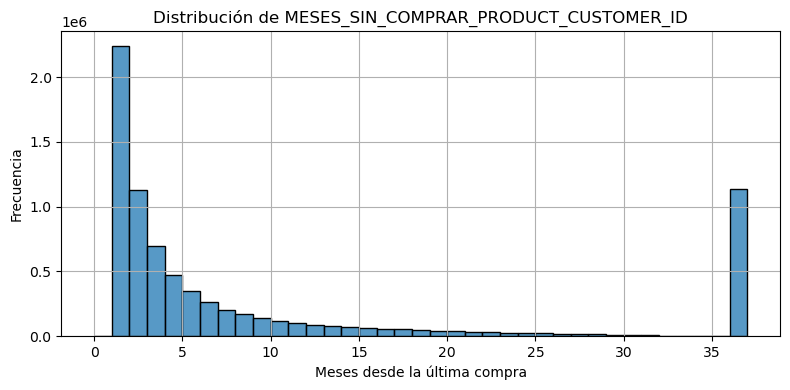

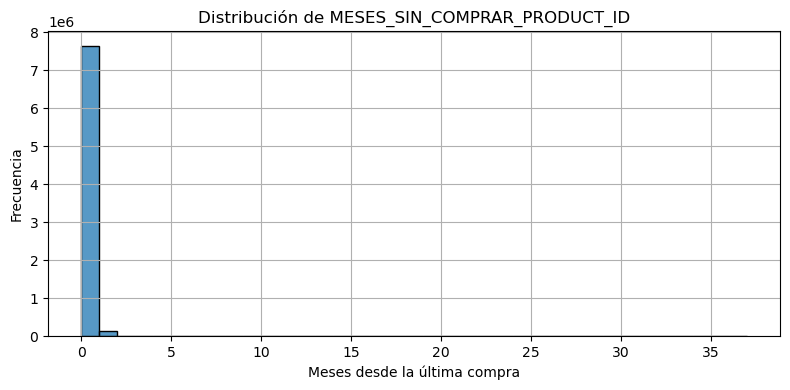

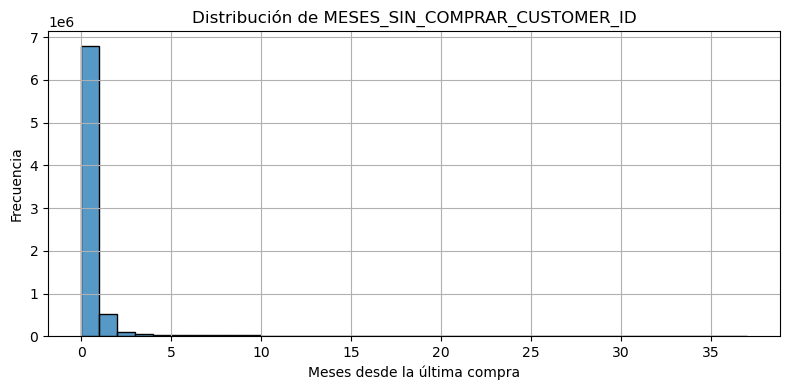

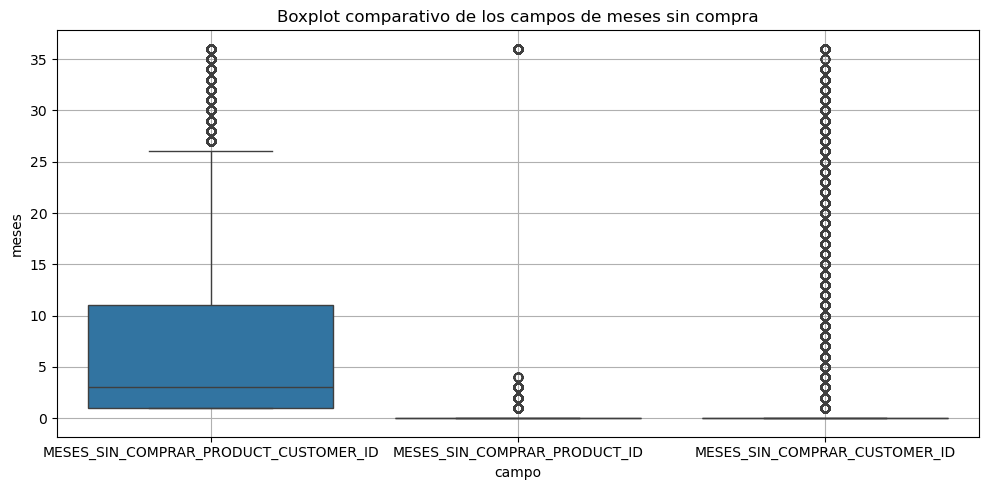

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de campos a analizar
campos = [
    'MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID',
    'MESES_SIN_COMPRAR_PRODUCT_ID',
    'MESES_SIN_COMPRAR_CUSTOMER_ID'
]

# Mostrar estadísticas descriptivas
print("🔍 Estadísticas Descriptivas:\n")
print(df_full[campos].describe().astype(int))

# Contar cuántos tienen valor 36 (nunca compró antes)
print("\n📊 Conteo de 36 (sin compra previa):\n")
for campo in campos:
    total = len(df_full)
    conteo = (df_full[campo] == 36).sum()
    porc = 100 * conteo / total
    print(f"{campo}: {conteo:,} ({porc:.2f}%)")

# Histograma de cada campo
for campo in campos:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_full[campo], bins=range(0, 38), kde=False)
    plt.title(f"Distribución de {campo}")
    plt.xlabel("Meses desde la última compra")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Boxplot comparativo
plt.figure(figsize=(10, 5))
df_melted = df_full[campos].melt(var_name='campo', value_name='meses')
sns.boxplot(data=df_melted, x='campo', y='meses')
plt.title("Boxplot comparativo de los campos de meses sin compra")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
df_full = optimizar_memoria(df_full)

In [16]:
# Filtrar columnas numéricas recientes sobre las que vale la pena transformar
cols_base = [col for col in df_full.columns if (
    (col.startswith('TN_DELTA_') and not col.endswith('_PORC'))
    or col.startswith('TN_LAG_')
    or col == 'TN'
    or col == 'CUST_REQUEST_TN'   
    or col == 'CUST_REQUEST_QTY'
    or col in ['MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID', 'MESES_SIN_COMPRAR_PRODUCT_ID', 'MESES_SIN_COMPRAR_CUSTOMER_ID']
    or col in ['ORDINAL', 'ANTIG_CLIENTE', 'ANTIG_PRODUCTO', 'CANT_PROD_CLI_PER']
)]
print(f"Columnas base para transformación: {cols_base}")

Columnas base para transformación: ['CUST_REQUEST_QTY', 'CUST_REQUEST_TN', 'TN', 'ORDINAL', 'ANTIG_CLIENTE', 'ANTIG_PRODUCTO', 'CANT_PROD_CLI_PER', 'TN_LAG_01', 'TN_DELTA_01', 'TN_LAG_02', 'TN_DELTA_02', 'TN_LAG_03', 'TN_DELTA_03', 'TN_LAG_04', 'TN_DELTA_04', 'TN_LAG_05', 'TN_DELTA_05', 'TN_LAG_06', 'TN_DELTA_06', 'TN_LAG_07', 'TN_DELTA_07', 'TN_LAG_08', 'TN_DELTA_08', 'TN_LAG_09', 'TN_DELTA_09', 'TN_LAG_10', 'TN_DELTA_10', 'TN_LAG_11', 'TN_DELTA_11', 'TN_LAG_12', 'TN_DELTA_12', 'TN_LAG_13', 'TN_DELTA_13', 'TN_LAG_14', 'TN_DELTA_14', 'TN_LAG_15', 'TN_DELTA_15', 'TN_LAG_16', 'TN_DELTA_16', 'TN_LAG_17', 'TN_DELTA_17', 'TN_DELTA_PCT_01', 'TN_DELTA_PCT_02', 'TN_DELTA_PCT_03', 'TN_DELTA_PCT_04', 'TN_DELTA_PCT_05', 'TN_DELTA_PCT_06', 'TN_DELTA_PCT_07', 'TN_DELTA_PCT_08', 'TN_DELTA_PCT_09', 'TN_DELTA_PCT_10', 'TN_DELTA_PCT_11', 'TN_DELTA_PCT_12', 'TN_DELTA_PCT_13', 'TN_DELTA_PCT_14', 'TN_DELTA_PCT_15', 'TN_DELTA_PCT_16', 'TN_DELTA_PCT_17', 'MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID', 'MESES_SIN_C

In [17]:
def transformar_columna_en_memoria(df, col):
    if col not in df.columns:
        return None

    col_data = df[col].values  # Evita overhead de pandas internamente

    # Calcular cada transformación usando arrays
    df[f'{col}_SQ'] = np.square(col_data)
    df[f'{col}_SQRT'] = np.sqrt(np.abs(col_data)) * np.sign(col_data)
    df[f'{col}_LOG1P'] = np.log1p(np.abs(col_data)) * np.sign(col_data)

    # Liberar arrays intermedios (aunque pandas puede retenerlos por un tiempo)
    del col_data
    gc.collect()

# Procesar columna por columna (sin crear estructuras innecesarias)
for col in cols_base:
    transformar_columna_en_memoria(df_full, col)
    gc.collect()


/tmp/ipykernel_53846/247404005.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_LOG1P'] = np.log1p(np.abs(col_data)) * np.sign(col_data)
/tmp/ipykernel_53846/247404005.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_SQ'] = np.square(col_data)
/tmp/ipykernel_53846/247404005.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

In [18]:
from itertools import combinations

#columnas_a_combinar = cols_base[5:]  # Use a list, not a single string
# Agregar a columnas_a_combinar PERIODO, ANIO, MES, MES_SIN, MES_COS, TRIMESTRE
columnas_a_combinar = ['CUST_REQUEST_QTY','TN','ANTIG_PRODUCTO','ORDINAL', 
                       'MES_SIN', 'MES_COS', 'TRIMESTRE','MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID',
                       'TN_LAG_01', 'TN_LAG_02','TN_LAG_06',
                       'TN_LAG_11', 'TN_LAG_12', 'TN_DELTA_12']

for col1, col2 in combinations(columnas_a_combinar, 2): 
    df_full[f'{col1}_x_{col2}'] = df_full[col1] * df_full[col2]


/tmp/ipykernel_53846/522635589.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_full[f'{col1}_x_{col2}'] = df_full[col1] * df_full[col2]
/tmp/ipykernel_53846/522635589.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_full[f'{col1}_x_{col2}'] = df_full[col1] * df_full[col2]
/tmp/ipykernel_53846/522635589.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

In [19]:
df_full = optimizar_memoria(df_full)

In [20]:
print(f"Columnas después de transformaciones: {df_full.columns.tolist()}")
print(f"Forma del DataFrame: {df_full.shape}")

Columnas después de transformaciones: ['PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'CUSTOMER_ID', 'PRODUCT_ID', 'PLAN_PRECIOS_CUIDADOS', 'CUST_REQUEST_QTY', 'CUST_REQUEST_TN', 'TN', 'CLASE', 'CLASE_DELTA', 'ORDINAL', 'ANTIG_CLIENTE', 'ANTIG_PRODUCTO', 'CANT_PROD_CLI_PER', 'DIAS_EN_MES', 'TN_LAG_01', 'TN_DELTA_01', 'TN_LAG_02', 'TN_DELTA_02', 'TN_LAG_03', 'TN_DELTA_03', 'TN_LAG_04', 'TN_DELTA_04', 'TN_LAG_05', 'TN_DELTA_05', 'TN_LAG_06', 'TN_DELTA_06', 'TN_LAG_07', 'TN_DELTA_07', 'TN_LAG_08', 'TN_DELTA_08', 'TN_LAG_09', 'TN_DELTA_09', 'TN_LAG_10', 'TN_DELTA_10', 'TN_LAG_11', 'TN_DELTA_11', 'TN_LAG_12', 'TN_DELTA_12', 'TN_LAG_13', 'TN_DELTA_13', 'TN_LAG_14', 'TN_DELTA_14', 'TN_LAG_15', 'TN_DELTA_15', 'TN_LAG_16', 'TN_DELTA_16', 'TN_LAG_17', 'TN_DELTA_17', 'TN_DELTA_PCT_01', 'TN_DELTA_PCT_02', 'TN_DELTA_PCT_03', 'TN_DELTA_PCT_04', 'TN_DELTA_PCT_05', 'TN_DELTA_PCT_06', 'TN_DELTA_PCT_07', 'TN_DELTA_PCT_08', 'TN_DELTA_

In [21]:
# Convertir el DataFrame a un DataFrame de Polars
df_full = pl.from_pandas(df_full)

In [22]:
# 1. Filtrar columnas relevantes
columnas_a_normalizar = [
    col for col in df_full.columns
    if ('TN' in col or 'DELTA' in col or 'CLASE' in col or 'LAG' in col)
]

# 2. Inicializar DataFrame con combinaciones únicas
medias_y_desvios = df_full.select(['PRODUCT_ID', 'CUSTOMER_ID']).unique()

# 3. Calcular medias y desvíos por columna
resultados = []
for col in columnas_a_normalizar:
    if col in df_full.columns:
        resumen = (
            df_full
            .select(['PRODUCT_ID', 'CUSTOMER_ID', col])
            .group_by(['PRODUCT_ID', 'CUSTOMER_ID'])
            .agg([
                pl.col(col).mean().alias(f'{col}_MEDIA'),
                pl.col(col).std().alias(f'{col}_DESVIO')
            ])
        )
        resultados.append(resumen)

# 4. Combinar todos los resultados
medias_y_desvios = reduce(
    lambda df1, df2: df1.join(df2, on=['PRODUCT_ID', 'CUSTOMER_ID'], how='left'), 
    resultados
)
# Convertir los nulos en ceros
medias_y_desvios = medias_y_desvios.fill_null(0)

del resumen, resultados
gc.collect()

0

In [23]:
def normalizar_zscore_con_join(
    df_full: pl.DataFrame,
    medias_y_desvios: pl.DataFrame,
    columnas_a_normalizar: List[str],
    conservar_auxiliares: bool = False,
    epsilon: float = 1e-6,
    clip_value: float = 5.0,
    agregar_clip: bool = False
) -> pl.DataFrame:
    # 1. Armar columnas necesarias
    columnas_media = [f'{col}_MEDIA' for col in columnas_a_normalizar if f'{col}_MEDIA' in medias_y_desvios.columns]
    columnas_desvio = [f'{col}_DESVIO' for col in columnas_a_normalizar if f'{col}_DESVIO' in medias_y_desvios.columns]
    columnas_join = ['PRODUCT_ID', 'CUSTOMER_ID'] + columnas_media + columnas_desvio

    # 2. Join
    df_aux = medias_y_desvios.select(columnas_join)
    df_full = df_full.join(df_aux, on=['PRODUCT_ID', 'CUSTOMER_ID'], how='left')

    # 3. Calcular ZSCOREs
    zscore_exprs = []
    for col in columnas_a_normalizar:
        media_col = f"{col}_MEDIA"
        desvio_col = f"{col}_DESVIO"
        z_col = f"{col}_ZSCORE"
        if media_col in df_full.columns and desvio_col in df_full.columns:
            expr = (
                (pl.col(col) - pl.col(media_col)) /
                (pl.col(desvio_col) + epsilon)
            ).alias(z_col)
            zscore_exprs.append(expr)
            print(f"✅ Normalizando: {col} -> {z_col}")

    df_full = df_full.with_columns(zscore_exprs)

    # 4. Clipping (después de que los zscores existen)
    if agregar_clip:
        clip_exprs = [
            pl.col(f"{col}_ZSCORE").clip(-clip_value, clip_value).alias(f"{col}_ZSCORE_CLIP")
            for col in columnas_a_normalizar
            if f"{col}_ZSCORE" in df_full.columns
        ]
        df_full = df_full.with_columns(clip_exprs)

    # 5. Eliminar auxiliares si no se quieren
    if not conservar_auxiliares:
        df_full = df_full.drop(columnas_media + columnas_desvio)

    return df_full

In [24]:
df_full = normalizar_zscore_con_join(
    df_full=df_full,
    medias_y_desvios=medias_y_desvios,
    columnas_a_normalizar=columnas_a_normalizar,
    conservar_auxiliares=False,
    epsilon=1e-6,
    clip_value=5.0,
    agregar_clip=False
)

✅ Normalizando: CUST_REQUEST_TN -> CUST_REQUEST_TN_ZSCORE
✅ Normalizando: TN -> TN_ZSCORE
✅ Normalizando: CLASE -> CLASE_ZSCORE
✅ Normalizando: CLASE_DELTA -> CLASE_DELTA_ZSCORE
✅ Normalizando: TN_LAG_01 -> TN_LAG_01_ZSCORE
✅ Normalizando: TN_DELTA_01 -> TN_DELTA_01_ZSCORE
✅ Normalizando: TN_LAG_02 -> TN_LAG_02_ZSCORE
✅ Normalizando: TN_DELTA_02 -> TN_DELTA_02_ZSCORE
✅ Normalizando: TN_LAG_03 -> TN_LAG_03_ZSCORE
✅ Normalizando: TN_DELTA_03 -> TN_DELTA_03_ZSCORE
✅ Normalizando: TN_LAG_04 -> TN_LAG_04_ZSCORE
✅ Normalizando: TN_DELTA_04 -> TN_DELTA_04_ZSCORE
✅ Normalizando: TN_LAG_05 -> TN_LAG_05_ZSCORE
✅ Normalizando: TN_DELTA_05 -> TN_DELTA_05_ZSCORE
✅ Normalizando: TN_LAG_06 -> TN_LAG_06_ZSCORE
✅ Normalizando: TN_DELTA_06 -> TN_DELTA_06_ZSCORE
✅ Normalizando: TN_LAG_07 -> TN_LAG_07_ZSCORE
✅ Normalizando: TN_DELTA_07 -> TN_DELTA_07_ZSCORE
✅ Normalizando: TN_LAG_08 -> TN_LAG_08_ZSCORE
✅ Normalizando: TN_DELTA_08 -> TN_DELTA_08_ZSCORE
✅ Normalizando: TN_LAG_09 -> TN_LAG_09_ZSCORE
✅ Normal

In [25]:
# Guardo el DataFrame resultante de medias y desvios en un archivo parquet para utilizarlo en el futuro
# (esto es útil para no tener que recalcularlo cada vez)
# y para que otros scripts puedan usarlo sin recalcularlo.
# Libero memoria de medias_y_desvios 
medias_y_desvios_pd = medias_y_desvios.to_pandas()
medias_y_desvios_pd.to_parquet('./data/medias_y_desvios.parquet', engine='fastparquet', index=False)
del medias_y_desvios_pd, medias_y_desvios
gc.collect()

0

In [26]:

# Eliminar las columnas originales de df_full que fueron normalizadas
# son las que están en columnas_a_normalizar
df_full = df_full.drop(columnas_a_normalizar)

In [27]:
# Convertir de nuevo a DataFrame de Pandas
df_full = df_full.to_pandas()

In [28]:
df_full = optimizar_memoria(df_full)

In [29]:
df_full.to_parquet('./data/tmp_intermedio.parquet', engine='fastparquet', index=False)

In [30]:
del df_full
gc.collect()

0

In [31]:
# Continuar desde aquí si falla
df_full = pd.read_parquet('./data/tmp_intermedio.parquet', engine='fastparquet')

In [32]:
df_full = optimizar_memoria(df_full)
gc.collect

<function gc.collect(generation=2)>

In [33]:
# --- Cálculo de features por grupo ---
def calcular_pendientes_grupo(group, periodos_list):
    group = group.sort_values(by='PERIODO').copy()
    n = len(group)
    y_series = pd.Series(group['TN_ZSCORE'].values)

    new_cols = {}

    for cant in periodos_list:
        x = np.arange(cant)
        rolling = y_series.rolling(window=cant, min_periods=1)

        # Medidas estadísticas
        mean_vals = rolling.mean().values
        std_vals = rolling.std().values
        median_vals = rolling.median().values
        min_vals = rolling.min().values
        max_vals = rolling.max().values
        ewma_vals = y_series.ewm(span=cant, adjust=False).mean().values

        new_cols[f'TN_MEAN_ZSCORE_{cant}'] = mean_vals
        new_cols[f'TN_STD_ZSCORE_{cant}'] = std_vals
        new_cols[f'TN_MEDIAN_ZSCORE_{str(cant).zfill(2)}'] = median_vals
        new_cols[f'TN_MIN_ZSCORE_{str(cant).zfill(2)}'] = min_vals
        new_cols[f'TN_MAX_ZSCORE_{str(cant).zfill(2)}'] = max_vals
        new_cols[f'TN_EWMA_ZSCORE_{str(cant).zfill(2)}'] = ewma_vals

        # Pendiente de regresión lineal
        if n >= cant:
            y_rolling = np.lib.stride_tricks.sliding_window_view(y_series.values, window_shape=cant)
            X = np.vstack([x, np.ones(cant)]).T
            XTX_inv_XT = np.linalg.pinv(X)
            betas = XTX_inv_XT @ y_rolling.T
            pendientes = np.full(n, np.nan)
            pendientes[cant - 1:] = betas[0]
        else:
            pendientes = np.full(n, np.nan)
        new_cols[f'PENDIENTE_TENDENCIA_ZSCORE_{cant}'] = pendientes

        # Medidas de variabilidad respecto a la media
        abs_diff = np.abs(y_series.values - mean_vals)
        cv_vals = std_vals / np.where(mean_vals == 0, np.nan, mean_vals)

        new_cols[f'TN_ABS_DIFF_MEAN_ZSCORE_{cant}'] = abs_diff
        new_cols[f'TN_CV_ZSCORE_{cant}'] = cv_vals

    df_features = pd.DataFrame(new_cols, index=group.index)
    group = pd.concat([group, df_features], axis=1)
    return group

# --- Procesar un chunk de grupos ---
def procesar_chunk(chunk, periodos_list):
    return pd.concat([calcular_pendientes_grupo(g, periodos_list) for g in chunk], ignore_index=True)

# --- Paralelización eficiente ---
def calcular_pendientes_parallel_optimizado(df, periodos_list, n_jobs=28, chunk_size=100):
    df = df.copy()  # conserva todas las columnas originales
    grupos = [group for _, group in df.groupby(['PRODUCT_ID', 'CUSTOMER_ID'])]
    chunks = list(chunked(grupos, chunk_size))

    resultados = Parallel(n_jobs=n_jobs, backend='loky', verbose=10)(
        delayed(procesar_chunk)(chunk, periodos_list) for chunk in chunks
    )

    df_final = pd.concat(resultados, ignore_index=True)
    return df_final

# --- Script principal ---
if __name__ == "__main__":
    import time
    start = time.time()

    df_full = calcular_pendientes_parallel_optimizado(
        df_full,
        periodos_list=[2, 3, 6, 9, 12, 13,15,18],
        n_jobs=28,
        chunk_size=200
    )

    print(f"Tiempo total: {time.time() - start:.2f} segundos")


[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:    2.6s
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:    2.6s
[Parallel(n_jobs=28)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=28)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=28)]: Done  57 tasks      | elapsed:    4.7s
[Parallel(n_jobs=28)]: Done  57 tasks      | elapsed:    4.7s
[Parallel(n_jobs=28)]: Done  72 tasks      | elapsed:    5.9s
[Parallel(n_jobs=28)]: Done  72 tasks      | elapsed:    5.9s
[Parallel(n_jobs=28)]: Done  89 tasks      | elapsed:    7.2s
[Parallel(n_jobs=28)]: Done  89 tasks      | elapsed:    7.2s
[Parallel(n_jobs=28)]: Done 106 tasks      | elapsed:  

Tiempo total: 115.38 segundos


In [34]:
df_full.to_parquet('./data/tmp_intermedio.parquet', engine='fastparquet', index=False)

In [35]:
# Continuar desde aquí si falla
df_full = pd.read_parquet('./data/tmp_intermedio.parquet', engine='fastparquet')

In [36]:
# Umbral: proporción máxima permitida (ej. 0.4 = 40%)
umbral_faltantes = 0.8

# Diccionario para almacenar estadísticas
estadisticas_columnas = []

# Recorremos las columnas del DataFrame
for col in df_full.columns:
    total = len(df_full[col])
    nulls = df_full[col].isnull().sum()
    nans = df_full[col].isna().sum()
    infs = np.isinf(df_full[col]).sum()
    
    total_faltantes = nulls + infs  # NaN está incluido en nulls/isna
    
    porcentaje = total_faltantes / total
    
    estadisticas_columnas.append({
        'columna': col,
        'nulls': nulls,
        'NaNs': nans,
        'infs': infs,
        'porcentaje_faltantes': porcentaje
    })

# Convertir a DataFrame
df_faltantes = pd.DataFrame(estadisticas_columnas)

# Filtrar columnas que superen el umbral
columnas_a_eliminar = df_faltantes[df_faltantes['porcentaje_faltantes'] > umbral_faltantes]

# Mostrar resumen
print(f"\nSe eliminarán {len(columnas_a_eliminar)} columnas con más del {umbral_faltantes*100:.0f}% de valores faltantes o infinitos:")
for _, row in columnas_a_eliminar.iterrows():
    print(f"- {row['columna']}: {row['porcentaje_faltantes']*100:.2f}% (nulls={row['nulls']}, infs={row['infs']})")

# Eliminar columnas del DataFrame
df_full = df_full.drop(columns=columnas_a_eliminar['columna'].tolist())


Se eliminarán 0 columnas con más del 80% de valores faltantes o infinitos:


In [37]:
# Agregar a df_resultado una variable categorica MES_PROBLEMATICO que sea 1 si PERIODO es 201906 o 201908 o 201910, y 0 en caso contrario
df_full['MES_PROBLEMATICO'] = df_full['PERIODO'].apply(lambda x: True if x in [201906, 201908] else False)
df_full['PLAN_PRECIOS_CUIDADOS'] = df_full['PLAN_PRECIOS_CUIDADOS'].map({1 : True, 0: False})

In [38]:
df_full = optimizar_memoria(df_full)

In [ ]:
# Eliminar estas columnas que no son necesarias
columnas_a_eliminar = ['ANTIG_PRODUCTO_x_ORDINAL', 'TN_LAG_14_LOG1P_ZSCORE', 'TN_DELTA_08_SQ_ZSCORE', 'TRIMESTRE_x_TN_LAG_12_ZSCORE', 'TN_STD_ZSCORE_3', 
                       'TN_DELTA_12_ZSCORE', 'TN_MEAN_ZSCORE_2', 'ANTIG_PRODUCTO_x_TN_LAG_06_ZSCORE', 'TN_LAG_14_ZSCORE', 'CUST_REQUEST_QTY_SQ', 
                       'TN_DELTA_PCT_16_ZSCORE', 'TN_DELTA_01_SQ_ZSCORE', 'TN_LAG_15_LOG1P_ZSCORE', 'TN_DELTA_PCT_16_LOG1P_ZSCORE', 'TN_DELTA_11_LOG1P_ZSCORE', 
                       'PENDIENTE_TENDENCIA_ZSCORE_2', 'TN_ABS_DIFF_MEAN_ZSCORE_2', 'TN_LAG_15_ZSCORE', 'TN_DELTA_01_LOG1P_ZSCORE', 'TN_LAG_02_LOG1P_ZSCORE', 
                       'TN_DELTA_PCT_04_ZSCORE', 'TN_DELTA_09_LOG1P_ZSCORE', 'MES_COS', 'MES_COS_x_TN_LAG_11_ZSCORE', 'TN_DELTA_PCT_02_ZSCORE', 
                       'TN_LAG_12_SQRT_ZSCORE', 'ANTIG_PRODUCTO_x_TN_LAG_02_ZSCORE', 'TN_DELTA_01_ZSCORE', 'TN_DELTA_PCT_17_SQ_ZSCORE', 'MES_COS_x_TRIMESTRE', 
                       'ORDINAL_x_TRIMESTRE', 'MES_COS_x_TN_LAG_12_ZSCORE', 'CUST_REQUEST_TN_SQ_ZSCORE', 'TN_DELTA_09_SQ_ZSCORE', 
                       'TRIMESTRE_x_MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID', 'ANTIG_PRODUCTO_x_MES_COS', 'MES_COS_x_TN_LAG_01_ZSCORE', 
                       'PENDIENTE_TENDENCIA_ZSCORE_3', 'TN_DELTA_02_ZSCORE', 'MES_SIN_x_TN_LAG_02_ZSCORE', 'TN_x_MES_COS_ZSCORE', 'MES_COS_x_TN_LAG_06_ZSCORE']
df_full = df_full.drop(columns=columnas_a_eliminar)

In [39]:
print(df_full.shape)
# Guardar el DataFrame resultante en un archivo parquet
df_full.to_parquet('./data/l_vm_completa_normalizada_fe.parquet', engine='fastparquet', index=False)

(7781619, 425)
